In [47]:
import numpy as np 
import xarray as xr 
import datetime as dt
import matplotlib.pyplot as plt 
from matplotlib.patches import Polygon
import cartopy.crs as ccrs 
import colorcet as ccet 
from scipy import ndimage
from retrieve_era5_fields_nc import *


In [48]:
# Panels:
# a. Initial shape and first dilation           b. 

# Choose a time
dt1 = dt.datetime(2003,10,20,12,0,0)
# dt1 = dt.datetime(2005,12,20,12,0,0)
# dt1 = dt.datetime(2024,2,4,12,0,0)

plot_area = [125, 315, -60, 60]

verbose = True

In [49]:
def reorder_image_labels(label_im):
    label_im_new = label_im.copy()
    unique_labels = sorted(np.unique(label_im))
    for n, label in enumerate(unique_labels):
        if n > 0:
            label_im_new[label_im == label] = n
    return (label_im_new, len(unique_labels)-1)

def ndimage_label_periodic_x(image):
    label_im, labels = ndimage.label(image)

    more_changes = True
    while more_changes:
        more_changes = False
        west_edge_ids = []
        east_edge_ids = []
        for n in range(1, labels+1):
            # Check left side.
            this_feature = label_im == n
            if np.sum(this_feature[:,0]) > 0:
                west_edge_ids += [n]
            # Check right side.
            if np.sum(this_feature[:,-1]) > 0:
                east_edge_ids += [n]

        # Check whether the western and eastern edge features should be combined.
        changes = 0
        for n in west_edge_ids:
            this_feature_n = label_im == n
            for m in east_edge_ids:
                if not m == n: # Check if already the same id.
                    this_feature_m = label_im == m
                    if np.nansum(np.logical_and(this_feature_n[:,0], this_feature_m[:,-1])):
                        # I have a match! So set the east edge system to the west edge ID.
                        label_im[this_feature_m] = n
                        changes += 1

        if changes > 0:
            label_im, labels = reorder_image_labels(label_im)
            more_changes = True

    return (label_im, labels)


In [50]:
F = retrieve_era5_fields_nc(dt1, verbose=verbose)
lon, lat = np.meshgrid(F['lon'], F['lat'])
tpw = F['tpw']
viwve = F['viwve']
viwvn = F['viwvn']
ivt = np.sqrt(np.power(viwve,2)+np.power(viwvn,2))

# Apply filter
tpw_filtered = ndimage.gaussian_laplace(tpw, [5,5], truncate=2)

area = np.abs(111.0*111.0*0.25*0.25*np.cos(np.pi*lat/180.0))


/home/orca/data/model_anal/era5/from_rda/tcwv/e5.oper.an.sfc.128_137_tcwv.ll025sc.2003100100_2003103123.nc
/home/orca/data/model_anal/era5/from_rda/viwve/e5.oper.an.vinteg.162_071_viwve.ll025sc.2003100100_2003103123.nc
/home/orca/data/model_anal/era5/from_rda/viwvn/e5.oper.an.vinteg.162_072_viwvn.ll025sc.2003100100_2003103123.nc
/home/orca/data/model_anal/era5/from_rda/v_200mb/2003/10/e5.oper.an.pl.128_132_v.ll025uv.2003102000_2003102023.lev200mb.6hr.nc
/home/orca/data/model_anal/era5/from_rda/u_200mb/2003/10/e5.oper.an.pl.128_131_u.ll025uv.2003102000_2003102023.lev200mb.6hr.nc
/home/orca/data/model_anal/era5/from_rda/invariant/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc


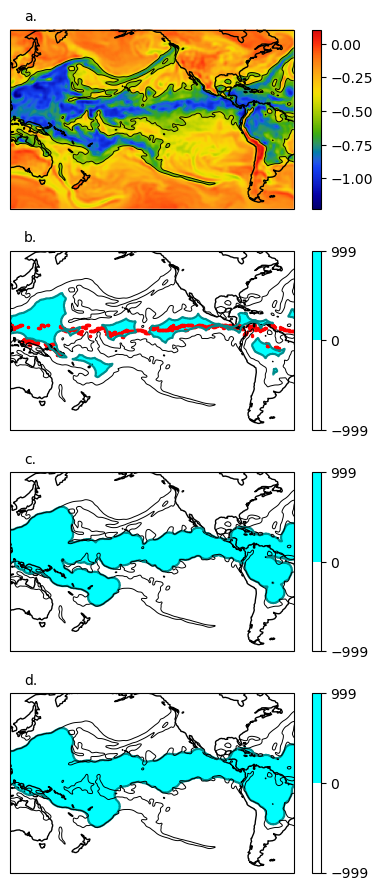

In [53]:
fig = plt.figure(figsize=(4,9))

central_longitude = 180
ax1 = fig.add_subplot(4,1,1, projection=ccrs.PlateCarree(central_longitude=central_longitude)) 
ax2 = fig.add_subplot(4,1,2, projection=ccrs.PlateCarree(central_longitude=central_longitude)) 
ax3 = fig.add_subplot(4,1,3, projection=ccrs.PlateCarree(central_longitude=central_longitude)) 
ax4 = fig.add_subplot(4,1,4, projection=ccrs.PlateCarree(central_longitude=central_longitude)) 

for ax in [ax1,ax2,ax3, ax4]:
    ax.coastlines()
    ax.set_extent(plot_area, crs=ccrs.PlateCarree())

H1 = ax1.pcolormesh(lon, lat, tpw_filtered,
    cmap='cet_rainbow4', transform=ccrs.PlateCarree())
# vmin=0.0, vmax=60.0,

H11 = ax1.contour(lon, lat, tpw_filtered, levels=[-0.5,],
    colors='k', linewidths=0.7, linestyles='-', transform=ccrs.PlateCarree())

plt.colorbar(H1)

# The first contraction

shape_radius = int(5.0 / 0.25)

shape = np.zeros([2*shape_radius+1, 2*shape_radius+1])
x, y = np.meshgrid(
    np.arange(-1*shape_radius, shape_radius+1),
    np.arange(-1*shape_radius, shape_radius+1))
shape_dist = np.sqrt(np.power(x,2) + np.power(y,2))
shape[shape_dist <= shape_radius] = 1

deep_tropics_mask0 = tpw_filtered < -0.5

deep_tropics_mask_step1 = ndimage.binary_erosion(deep_tropics_mask0, shape)
H2 = ax2.contourf(lon, lat, deep_tropics_mask_step1, levels=[-999.0,0.5,999.0],
    colors = ['none','cyan'], transform=ccrs.PlateCarree())
ax2.contour(lon, lat, deep_tropics_mask_step1, levels=[0.5,],
    colors = 'darkcyan', transform=ccrs.PlateCarree())
cax2 = plt.colorbar(H2)

ax2.contour(lon, lat, tpw_filtered, levels=[-0.5,],
    colors='k', linewidths=0.7, linestyles='-', transform=ccrs.PlateCarree())

# Fill in Gap.
deep_tropics_mask_step2 = deep_tropics_mask_step1.copy()

for ii in range(len(tpw[0,:])):
    # if np.nansum(deep_tropics_mask[:,ii]) < 1:
        # Fill in the "gap" in longitude.
    this_tpw_col = 1.0*tpw[:,ii]
    this_tpw_col[np.abs(lat[:,0]) > 10] = 0.0

    jmax = np.argmax(this_tpw_col)
    ax2.scatter(lon[jmax,ii], lat[jmax,ii], c='red', s=2, transform=ccrs.PlateCarree())
    deep_tropics_mask_step2[np.argmax(this_tpw_col),ii] = 1


deep_tropics_mask_step2 = ndimage.binary_dilation(deep_tropics_mask_step2, shape)


#Largest features, and Estra binary closing.
mask_labeled, nb_labels = ndimage_label_periodic_x(deep_tropics_mask_step2)
for n in range(1,nb_labels+1):
    # print(np.nansum(area * (mask_labeled==n)))
    if np.nansum(area * (mask_labeled==n)) < 1e7:
        deep_tropics_mask_step2[mask_labeled == n] = 0

H3 = ax3.contourf(lon, lat, deep_tropics_mask_step2, levels=[-999.0,0.5,999.0],
    colors = ['none','cyan'], transform=ccrs.PlateCarree())
ax3.contour(lon, lat, deep_tropics_mask_step2, levels=[0.5,],
    colors = 'darkcyan', transform=ccrs.PlateCarree())
cax3 = plt.colorbar(H3)

ax3.contour(lon, lat, tpw_filtered, levels=[-0.5,],
    colors='k', linewidths=0.7, linestyles='-', transform=ccrs.PlateCarree())


# Taking out the concave "kinks"
deep_tropics_mask_alt = deep_tropics_mask_step2.copy()
n_pad_x = shape.shape[0]
deep_tropics_mask_alt_padded = np.append(deep_tropics_mask_alt[:,0:n_pad_x], deep_tropics_mask_alt, axis=1)
deep_tropics_mask_alt_padded = np.append(deep_tropics_mask_alt_padded, deep_tropics_mask_alt[:,-1*n_pad_x:], axis=1)
deep_tropics_mask_alt_padded = ndimage.binary_closing(deep_tropics_mask_alt_padded, structure=shape)
deep_tropics_mask_alt = deep_tropics_mask_alt_padded[:,n_pad_x:-1*n_pad_x]

deep_tropics_mask_step3 = deep_tropics_mask_alt.copy()

H4 = ax4.contourf(lon, lat, deep_tropics_mask_step3, levels=[-999.0,0.5,999.0],
    colors = ['none','cyan'], transform=ccrs.PlateCarree())
ax4.contour(lon, lat, deep_tropics_mask_step3, levels=[0.5,],
    colors = 'darkcyan', transform=ccrs.PlateCarree())
cax4 = plt.colorbar(H4)


ax4.contour(lon, lat, tpw_filtered, levels=[-0.5,],
    colors='k', linewidths=0.7, linestyles='-', transform=ccrs.PlateCarree())


def add_panel_label(ax, label):
    ax.text(0.05, 1.05, label, transform=ax.transAxes)

add_panel_label(ax1, 'a.')
add_panel_label(ax2, 'b.')
add_panel_label(ax3, 'c.')
add_panel_label(ax4, 'd.')

plt.tight_layout()

plt.savefig('deep_tropics_mask_steps.png')
